In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# these come with python
import io
import zipfile
import functools

# you can install these packages using pip or anaconda
# (requests numpy pandas bokeh pyproj statsmodels)

# for downloading
import requests
%matplotlib inline

In [2]:
hdf = pd.HDFStore('stationData.h5') # depends on PyTables
keys = hdf.keys()

In [3]:
hdf

<class 'pandas.io.pytables.HDFStore'>
File path: stationData.h5
/DELFZL/year1879               frame_table  (typ->appendable,nrows->2920,ncols->1,indexers->[index])  
/DELFZL/year1880               frame_table  (typ->appendable,nrows->2928,ncols->1,indexers->[index])  
/DELFZL/year1881               frame_table  (typ->appendable,nrows->2920,ncols->1,indexers->[index])  
/DELFZL/year1882               frame_table  (typ->appendable,nrows->2920,ncols->1,indexers->[index])  
/DELFZL/year1883               frame_table  (typ->appendable,nrows->2920,ncols->1,indexers->[index])  
/DELFZL/year1884               frame_table  (typ->appendable,nrows->2928,ncols->1,indexers->[index])  
/DELFZL/year1885               frame_table  (typ->appendable,nrows->2920,ncols->1,indexers->[index])  
/DELFZL/year1886               frame_table  (typ->appendable,nrows->2920,ncols->1,indexers->[index])  
/DELFZL/year1887               frame_table  (typ->appendable,nrows->2920,ncols->1,indexers->[index])  
/DELFZL/y

In [4]:
columns = ['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD', 'IJMDBTHVN', 'IJMDNDSS', 'VLISSGN']
index = pd.date_range('1850','2018', freq='A')
df = pd.DataFrame(index=index, columns=columns, dtype=float)

In [5]:
for station in tqdm(columns):
    print (station+' ', end='')
    for year in index:        
        key = '/'+station+'/year'+str(year.year)
        if key in keys:
            print ('.',end='')
            annual_mean = hdf[key].astype(float).mean()[0]
            df.set_value(str(year), station, annual_mean) 
    print ('✓')

DELFZL ...........................................................................................................................................✓
DENHDR ......................................................................................✓
HARLGN ................................................................................✓
HOEKVHLD .........................................................................................✓
IJMDBTHVN ......................................✓
IJMDNDSS ...............................................................................✓
VLISSGN ............................................................................................................................✓



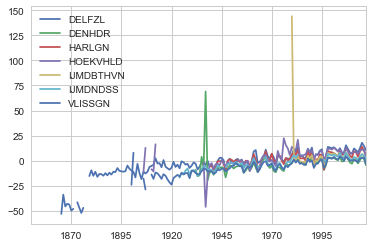

In [6]:
df.plot()

In [7]:
df['DELFZL']

1850-12-31          NaN
1851-12-31          NaN
1852-12-31          NaN
1853-12-31          NaN
1854-12-31          NaN
1855-12-31          NaN
1856-12-31          NaN
1857-12-31          NaN
1858-12-31          NaN
1859-12-31          NaN
1860-12-31          NaN
1861-12-31          NaN
1862-12-31          NaN
1863-12-31          NaN
1864-12-31          NaN
1865-12-31          NaN
1866-12-31          NaN
1867-12-31          NaN
1868-12-31          NaN
1869-12-31          NaN
1870-12-31          NaN
1871-12-31          NaN
1872-12-31          NaN
1873-12-31          NaN
1874-12-31          NaN
1875-12-31          NaN
1876-12-31          NaN
1877-12-31          NaN
1878-12-31          NaN
1879-12-31   -15.267466
                ...    
1988-12-31    11.985640
1989-12-31     8.291296
1990-12-31    13.126018
1991-12-31     1.650860
1992-12-31     6.545223
1993-12-31     6.127625
1994-12-31    10.099483
1995-12-31    11.363159
1996-12-31    -2.938007
1997-12-31     4.728163
1998-12-31    13

In [8]:
PSMSL_ids = [32, 20, 9, 22, 23, 24, 25, 236, 1551]
PSMSL_locations = r'D:\jupyter notebooks\2695.40\Werkzaamheden\rlr_annual.zip'
dataset_name = 'rlr_annual'
# these compute the rlr back to NAP (ignoring the undoing of the NAP correction)
main_stations = {
    20: {
        'name': 'Vlissingen', 
        'rlr2nap': lambda x: x - (6976-46)
    },
    22: {
        'name': 'Hoek van Holland', 
        'rlr2nap': lambda x:x - (6994 - 121)
    },
    23: {
        'name': 'Den Helder', 
        'rlr2nap': lambda x: x - (6988-42)
    },
    24: {
        'name': 'Delfzijl', 
        'rlr2nap': lambda x: x - (6978-155)
    },
    25: {
        'name': 'Harlingen', 
        'rlr2nap': lambda x: x - (7036-122)
    },
    32: {
        'name': 'IJmuiden', 
        'rlr2nap': lambda x: x - (7033-83)
    },
    1551: {
        'name': 'Roompot buiten',
        'rlr2nap': lambda x: x - (7011-17)
    },
    9: {
        'name': 'Maassluis',
        'rlr2nap': lambda x: x - (6983-184)
    },
    236: {
        'name': 'West-Terschelling',
        'rlr2nap': lambda x: x - (7011-54)
    },
}


# Roompot Buiten, Haringvliet (zonder NAP-correctie), Maassluis en West-Terschelling

In [9]:
zf = zipfile.ZipFile(PSMSL_locations)

# this list contains a table of 
# station ID, latitude, longitude, station name, coastline code, station code, and quality flag
csvtext = zf.read('{}/filelist.txt'.format(dataset_name))

stations = pd.read_csv(
    io.BytesIO(csvtext), 
    sep=';',
    names=('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality'),
    converters={
        'name': str.strip,
        'quality': str.strip
    }
)
stations = stations.set_index('id')

# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = stations.loc[PSMSL_ids].copy()
# set the main stations, this should be a list of 6 stations
selected_stations

,lat,lon,name,coastline_code,station_code,quality
id,,,,,,
32,52.462222,4.554722,IJMUIDEN,150,41,N
20,51.442222,3.596111,VLISSINGEN,150,101,N
9,51.917500,4.249722,MAASSLUIS,150,61,N
22,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N
23,52.964444,4.745000,DEN HELDER,150,31,N
24,53.326389,6.933056,DELFZIJL,150,1,N
25,53.175556,5.409444,HARLINGEN,150,21,N
236,53.363056,5.220000,WEST-TERSCHELLING,150,11,N
1551,51.619722,3.681944,ROOMPOT BUITEN,150,90,N


In [10]:
# each station has a number of files that you can look at.
# here we define a template for each filename

# stations that we are using for our computation
# define the name formats for the relevant files
names = {
    'datum': '{dataset}/RLR_info/{id}.txt',
    'diagram': '{dataset}/RLR_info/{id}.png',
    'url': 'http://www.psmsl.org/data/obtaining/rlr.diagrams/{id}.php',
    'data': '{dataset}/data/{id}.rlrdata',
    'doc': '{dataset}/docu/{id}.txt',
    'contact': '{dataset}/docu/{id}_auth.txt'
}

In [11]:
def get_url(station, dataset):
    """return the url of the station information (diagram and datum)"""
    info = dict(
        dataset=dataset,
        id=station.name
    )
    url = names['url'].format(**info)
    return url
# fill in the dataset parameter using the global dataset_name
f = functools.partial(get_url, dataset=dataset_name)
# compute the url for each station
selected_stations['url'] = selected_stations.apply(f, axis=1)
selected_stations

,lat,lon,name,coastline_code,station_code,quality,url
id,,,,,,,
32,52.462222,4.554722,IJMUIDEN,150,41,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
20,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
9,51.917500,4.249722,MAASSLUIS,150,61,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
22,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
23,52.964444,4.745000,DEN HELDER,150,31,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
24,53.326389,6.933056,DELFZIJL,150,1,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
25,53.175556,5.409444,HARLINGEN,150,21,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
236,53.363056,5.220000,WEST-TERSCHELLING,150,11,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
1551,51.619722,3.681944,ROOMPOT BUITEN,150,90,N,http://www.psmsl.org/data/obtaining/rlr.diagra...


In [12]:
def missing2nan(value, missing=-99999):
    """convert the value to nan if the float of value equals the missing value"""
    value = float(value)
    if value == missing:
        return np.nan
    return value

def get_data(station, dataset):
    """get data for the station (pandas record) from the dataset (url)"""
    info = dict(
        dataset=dataset,
        id=station.name
    )
    bytes = zf.read(names['data'].format(**info))
    df = pd.read_csv(
        io.BytesIO(bytes), 
        sep=';', 
        names=('year', 'height', 'interpolated', 'flags'),
        converters={
            "height": lambda x: main_stations[station.name]['rlr2nap'](missing2nan(x)),
            "interpolated": str.strip,
        }
    )
    df['station'] = station.name
    return df

In [13]:
# get data for all stations
f = functools.partial(get_data, dataset=dataset_name)
# look up the data for each station
selected_stations['data'] = [f(station) for _, station in selected_stations.iterrows()]

In [14]:
# we now have data for each station
selected_stations[['name', 'data']]

,name,data
id,,
32,IJMUIDEN,year height interpolated flags station...
20,VLISSINGEN,year height interpolated flags station...
9,MAASSLUIS,year height interpolated flags station...
22,HOEK VAN HOLLAND,year height interpolated flags station...
23,DEN HELDER,year height interpolated flags station...
24,DELFZIJL,year height interpolated flags station...
25,HARLINGEN,year height interpolated flags station...
236,WEST-TERSCHELLING,year height interpolated flags station ...
1551,ROOMPOT BUITEN,year height interpolated flags station ...


In [15]:
columns_ = [i for i in selected_stations['name']]
df2 = pd.DataFrame(index=index, columns=columns_)

In [16]:
for name in tqdm(columns_):
    print (name)
    df_tmp = selected_stations[selected_stations['name']==name]['data'].iloc[0][['year', 'height']]
    for row in df_tmp.iterrows():
        df2.set_value(pd.Timestamp(str(int(row[1]['year']))+'-12-31', freq='A-DEC'),name,row[1]['height'])   
df2.sort_index(inplace=True)

IJMUIDEN
VLISSINGEN
MAASSLUIS
HOEK VAN HOLLAND
DEN HELDER
DELFZIJL
HARLINGEN
WEST-TERSCHELLING
ROOMPOT BUITEN



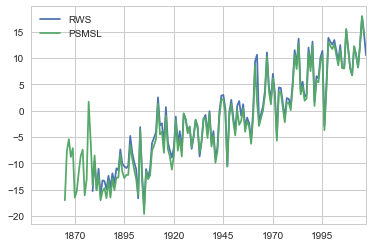

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1)

df['DELFZL'].plot(ax=ax, label='RWS')
(df2['DELFZIJL']/10).plot(ax=ax, label='PSMSL')
plt.legend()
plt.show()

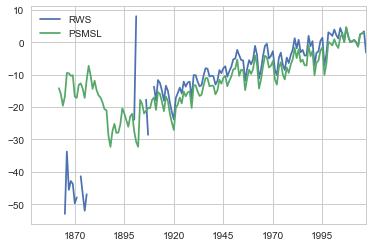

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)

df['VLISSGN'].plot(ax=ax, label='RWS')
(df2['VLISSINGEN']/10).plot(ax=ax, label='PSMSL')
plt.legend()
plt.show()

In [20]:
df['DELFZL'], df2['VLISSINGEN']

(1850-12-31          NaN
 1851-12-31          NaN
 1852-12-31          NaN
 1853-12-31          NaN
 1854-12-31          NaN
 1855-12-31          NaN
 1856-12-31          NaN
 1857-12-31          NaN
 1858-12-31          NaN
 1859-12-31          NaN
 1860-12-31          NaN
 1861-12-31          NaN
 1862-12-31          NaN
 1863-12-31          NaN
 1864-12-31          NaN
 1865-12-31          NaN
 1866-12-31          NaN
 1867-12-31          NaN
 1868-12-31          NaN
 1869-12-31          NaN
 1870-12-31          NaN
 1871-12-31          NaN
 1872-12-31          NaN
 1873-12-31          NaN
 1874-12-31          NaN
 1875-12-31          NaN
 1876-12-31          NaN
 1877-12-31          NaN
 1878-12-31          NaN
 1879-12-31   -15.267466
                 ...    
 1988-12-31    11.985640
 1989-12-31     8.291296
 1990-12-31    13.126018
 1991-12-31     1.650860
 1992-12-31     6.545223
 1993-12-31     6.127625
 1994-12-31    10.099483
 1995-12-31    11.363159
 1996-12-31    -2.938007
